In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# Loading CSV
df = pd.read_csv('/content/drive/MyDrive/movie_prediction_data/merged_movie_data_youtube.csv')

# Cleaning column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Converting data types
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
num_cols = ['budget', 'revenue', 'runtime', 'vote_average', 'vote_count']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Dropping rows with missing budget or revenue
df.dropna(subset=['budget', 'revenue'], inplace=True)

# Stripping and lowercasing text fields
text_cols = ['language', 'genres', 'production_companies', 'top_cast', 'keywords', 'status']
for col in text_cols:
    df[col] = df[col].astype(str).str.strip().str.lower()

# Splitting multi-value columns
df['genres_list'] = df['genres'].str.split(', ')
df['top_cast_list'] = df['top_cast'].str.split(', ')
df['keywords_list'] = df['keywords'].str.split(', ')

# Removing duplicate entries
df.drop_duplicates(subset=['movie_id', 'title'], inplace=True)

# Filtering out invalid rows
df = df[(df['budget'] >= 0) & (df['revenue'] >= 0) & (df['runtime'] > 0)]

# (TBD) Removing unwanted columns

# Previewing final dataset
df.head()


,movie_id,imdb_id,title,vote_average,vote_count,status,release_date,budget,revenue,popularity,...,avg_negative,avg_anger,avg_disgust,avg_fear,avg_joy,avg_sadness,avg_surprise,genres_list,top_cast_list,keywords_list
0,299534,tt4154796,Avengers: Endgame,8.238,26214,released,2019-04-24,356000000,2799439100,26.9856,...,0.133148,0.026608,0.012582,0.055366,0.166565,0.106501,0.256762,"[adventure, science fiction, action]","[robert downey jr., chris evans, mark ruffalo]","[superhero, time travel, space travel, time ma..."
1,76600,tt1630029,Avatar: The Way of Water,7.609,12445,released,2022-12-14,460000000,2320250281,24.4638,...,0.139885,0.030706,0.023026,0.030858,0.243219,0.097674,0.164241,"[science fiction, adventure, action]","[sam worthington, zoe saldaña, sigourney weaver]","[dying and death, loss of loved one, alien lif..."
2,140607,tt2488496,Star Wars: The Force Awakens,7.300,19667,released,2015-12-15,245000000,2068223624,13.0107,...,0.255515,0.044669,0.043038,0.040608,0.219704,0.152788,0.245296,"[adventure, action, science fiction]","[harrison ford, mark hamill, carrie fisher]","[android, spacecraft, space opera, requel]"
3,299536,tt4154756,Avengers: Infinity War,8.235,30394,released,2018-04-25,300000000,2052415039,34.0939,...,0.151861,0.051458,0.010258,0.055181,0.169691,0.085262,0.272625,"[adventure, action, science fiction]","[robert downey jr., chris evans, chris hemsworth]","[sacrifice, magic, superhero, based on comic, ..."
4,634649,tt10872600,Spider-Man: No Way Home,7.946,20666,released,2021-12-15,200000000,1921847111,30.3377,...,0.117586,0.025914,0.014453,0.029683,0.154757,0.093875,0.277602,"[action, adventure, science fiction]","[tom holland, zendaya, benedict cumberbatch]","[new york city, hero, showdown, magic, loss of..."


In [3]:
# Saving the cleaned dataset to a new CSV file
df.to_csv('/content/drive/MyDrive/movie_prediction_data/final_data_with_sentiment_scores_youtube.csv', index=False)

[0]	validation_0-rmse:2.13928	validation_1-rmse:1.87057
[80]	validation_0-rmse:0.06477	validation_1-rmse:0.85059

📊 Validation Results:
MAE: 27,428,472.27
RMSE: 83,891,228.97
Custom ±10M Accuracy: 72.00%

📊 Test Results:
MAE: 15,789,220.64
RMSE: 32,499,849.40
Custom ±10M Accuracy: 73.47%


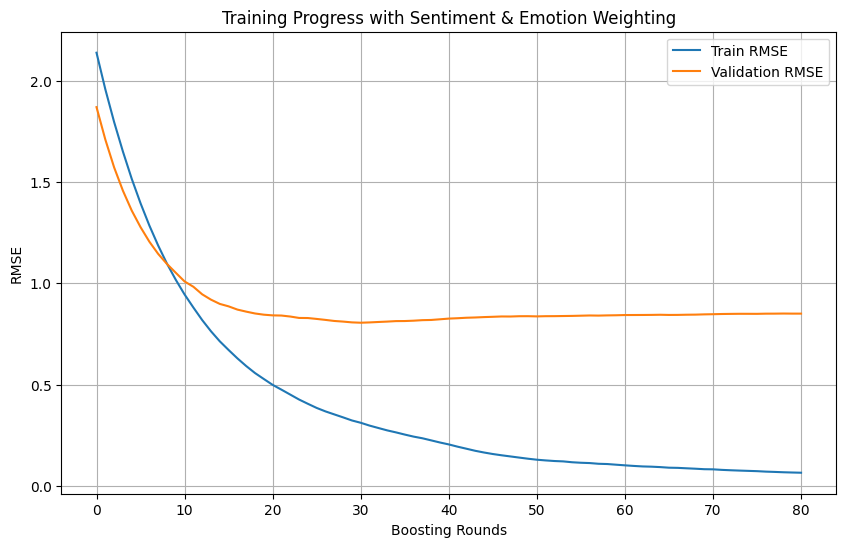

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# === 1. Loading enriched dataset ===
df = pd.read_csv('/content/drive/MyDrive/movie_prediction_data/final_data_with_sentiment_scores_youtube.csv')

# === 2. Converting release_date column to datetime format ===
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# === 3. Performing feature engineering ===
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df['cast_count'] = df['top_cast'].fillna('').str.split(', ').apply(len)
df['genre_count'] = df['genres'].fillna('').str.split(', ').apply(len)
df['keyword_count'] = df['keywords'].fillna('').str.split(', ').apply(len)

# Extracting top 50 directors and encoding others as 'other'
top_directors = df['director'].value_counts().nlargest(50).index
df['director_clean'] = df['director'].apply(lambda x: x if x in top_directors else 'other')

# Extracting top 50 production companies and encoding others as 'other'
df['main_prod_company'] = df['production_companies'].str.split(', ').str[0]
top_companies = df['main_prod_company'].value_counts().nlargest(50).index
df['main_prod_company'] = df['main_prod_company'].apply(lambda x: x if x in top_companies else 'other')

# Applying log transformation to the revenue column
df['log_revenue'] = np.log1p(df['revenue'])

# === 4. Applying one-hot encoding to categorical features ===
categorical_cols = ['language', 'status', 'main_prod_company', 'director_clean']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# === 5. Defining features and giving more weight to sentiment/emotion columns ===
sentiment_emotion_cols = [
    'avg_compound', 'avg_positive', 'avg_neutral', 'avg_negative',
    'avg_anger', 'avg_disgust', 'avg_fear', 'avg_joy',
    'avg_sadness', 'avg_surprise'
]

# Giving more weight (×3) to these columns
for col in sentiment_emotion_cols:
    df[col] = df[col] * 3

drop_cols = ['movie_id', 'imdb_id', 'title', 'revenue', 'release_date',
             'genres', 'top_cast', 'keywords', 'production_companies',
             'director', 'genres_list', 'top_cast_list', 'keywords_list']

features = [col for col in df.columns if col not in drop_cols + ['log_revenue']]
X = df[features]
y = df['log_revenue']

# === 6. Splitting dataset ===
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.15, random_state=42)

# === 7. Initializing the XGBoost model ===
model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror',
    eval_metric='rmse',
    early_stopping_rounds=50
)

# === 8. Training ===
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100
)

# === 9. Evaluation ===
def evaluate(model, X, y_true, label):
    y_pred = model.predict(X)
    y_pred_rev = np.expm1(y_pred)
    y_true_rev = np.expm1(y_true)

    mae = mean_absolute_error(y_true_rev, y_pred_rev)
    rmse = np.sqrt(mean_squared_error(y_true_rev, y_pred_rev))
    within_range = np.abs(y_pred_rev - y_true_rev) <= 10000000
    custom_acc = np.mean(within_range)

    print(f"\n📊 {label} Results:")
    print(f"MAE: {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"Custom ±10M Accuracy: {custom_acc * 100:.2f}%")

# === 10. Training Curve ===
def plot_training_progress(model):
    evals_result = model.evals_result()
    plt.figure(figsize=(10, 6))
    plt.plot(evals_result['validation_0']['rmse'], label='Train RMSE')
    plt.plot(evals_result['validation_1']['rmse'], label='Validation RMSE')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('RMSE')
    plt.title('Training Progress with Sentiment & Emotion Weighting')
    plt.legend()
    plt.grid(True)
    plt.show()

# === 11. Evaluation ===
evaluate(model, X_val, y_val, "Validation")
evaluate(model, X_test, y_test, "Test")

# === 12. Plotting ===
plot_training_progress(model)
